In [ ]:
import os,requests
def download(url):
    get_response = requests.get(url,stream=True)
    file_name  = "data.zip"
    with open(file_name, 'wb') as f:
        for chunk in get_response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

download("https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10200/868375/upload/train_simplified.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1744049325&Signature=WOYm2xtl6DMWm4HCEEzXH94yueZvxywCpsKrf0nTn0D7%2FOrdVWU1JvRdvPXsoGV8ArR333S%2FL3525YvBLrRayjXjd%2Fhx0%2FDHKgXFIJqMhRkVk4AxvZC65%2FZ1ru0Bu7wI7cQJ7V67sELGyLbVszqF%2FhxjTYPVKwekB%2FgxabFoJCgArZ%2FfNrqvMevYsvRJoona56J%2FEKkb802mXclNEafFaCoN6kQPsM6gUBxlQuPi85pwC48%2FL0YL09qJatbpRoy%2BnSX46cpanpJcMffkuVjnhwDf1sUdPzvVSKFYCm0AmHi8aD6jEj3t5hRGpdPDjCyn1n96C4K4kKaoTNWR%2B9PnuA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain_simplified.zip")

In [ ]:
import zipfile
with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
    zip_ref.extractall('./input')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
pip install mlflow

In [35]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import json
import os
import datetime as dt
from tqdm import tqdm
import pandas as pd
import numpy as np
import mlflow

In [36]:
def f2cat(filename: str) -> str:
    return filename.split('.')[0]

class Simplified():
    def __init__(self, input_path='./input'):
        self.input_path = input_path

    def list_all_categories(self):
        files = os.listdir(os.path.join(self.input_path))
        return sorted([f2cat(f) for f in files], key=str.lower)

    def read_training_csv(self, category, nrows=None, usecols=None, drawing_transform=False):
        df = pd.read_csv(os.path.join(self.input_path, category + '.csv'),
                         nrows=nrows, parse_dates=['timestamp'], usecols=usecols)
        if drawing_transform:
            df['drawing'] = df['drawing'].apply(json.loads)
        return df

In [37]:
start = dt.datetime.now()
s = Simplified('./input')
NCSVS = 100
categories = s.list_all_categories()
print(len(categories))

FileNotFoundError: [Errno 2] No such file or directory: './input'

In [ ]:
for y, cat in tqdm(enumerate(categories)):
    df = s.read_training_csv(cat, nrows=30000)
    df['y'] = y
    df['cv'] = (df.key_id // 10 ** 7) % NCSVS
    for k in range(NCSVS):
        filename = 'train_k{}.csv'.format(k)
        chunk = df[df.cv == k]
        chunk = chunk.drop(['key_id'], axis=1)
        if y == 0:
            chunk.to_csv(filename, index=False)
        else:
            chunk.to_csv(filename, mode='a', header=False, index=False)

321it [08:03,  1.55s/it]<ipython-input-6-a4096fc4c229>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(os.path.join(self.input_path, category + '.csv'),
340it [08:33,  1.51s/it]


In [ ]:
for k in tqdm(range(NCSVS)):
    filename = 'train_k{}.csv'.format(k)
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        df['rnd'] = np.random.rand(len(df))
        df = df.sort_values(by='rnd').drop('rnd', axis=1)
        df.to_csv(filename + '.gz', compression='gzip', index=False)
        os.remove(filename)
print(df.shape)

100%|██████████| 100/100 [1:02:41<00:00, 37.61s/it]

(102042, 7)


In [6]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

Latest run 2025-04-06 14:13:03.789294.
Total time 28s


In [38]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
start = dt.datetime.now()

In [39]:
#DP_DIR = './'
DP_DIR = '/content/drive/MyDrive/Colab Notebooks/data/'
INPUT_DIR = '../input/'

BASE_SIZE = 256
NCSVS = 74
NCATS = 340
np.random.seed(seed=1987)
tf.random.set_seed(1987)  # Correct method in TF 2.x

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [40]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [41]:
STEPS = 800
EPOCHS = 16
size = 64
batchsize = 680

In [42]:
model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(learning_rate=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

Model: "mobilenet_1.00_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 32, 32, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 32, 32, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 32, 32, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 32, 32, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 32, 32, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 33, 33, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 16, 16, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 16, 16, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 16, 16, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 16, 16, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 16, 16, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,576,788 (13.64 MB)

 Trainable params: 3,554,900 (13.56 MB)

 Non-trainable params: 21,888 (85.50 KB)

None


In [43]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [44]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 64, 64, 1) (34000, 340)
Validation array memory 0.52 GB


In [45]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

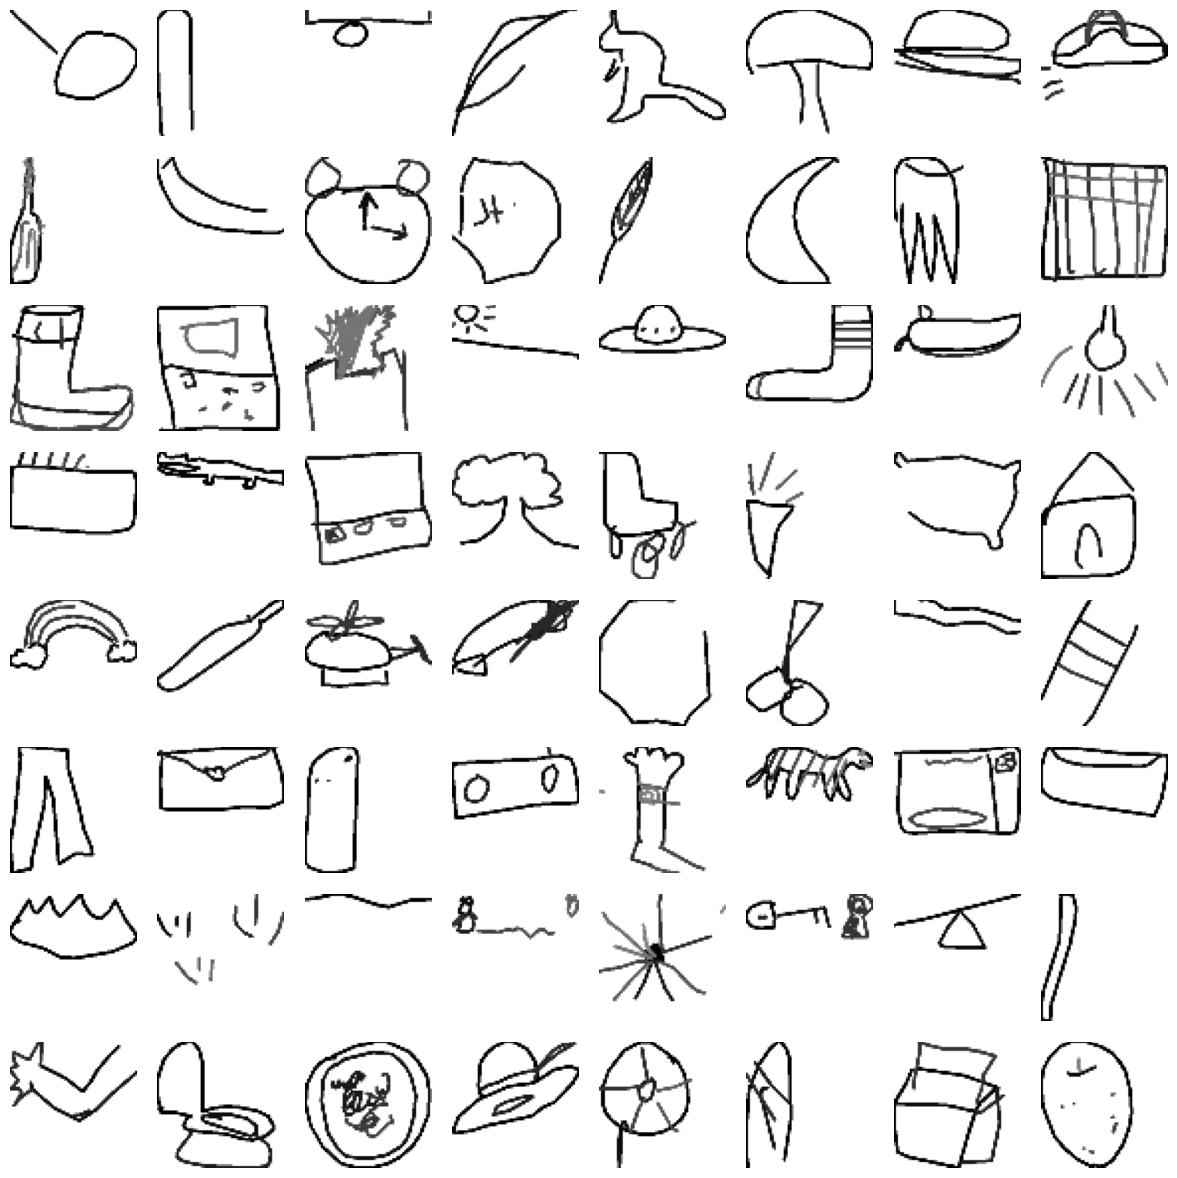

In [46]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [47]:
%%timeit
x, y = next(train_datagen)

105 ms ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
# Function to train and log model
def train_and_log_model(model, model_name):
    with mlflow.start_run():
        callbacks = [
            ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.75, patience=3, min_delta=0.001,
                                  mode='max', min_lr=1e-5, verbose=1),
            ModelCheckpoint('doodlemind_model.weights.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                            save_weights_only=True, save_freq='epoch', verbose=1),
            EarlyStopping(monitor='val_top_3_accuracy', min_delta=0.001, patience=5,
                          restore_best_weights=True, mode='max', verbose=1)
        ]
        # Train model
        hists = []
        hist = model.fit(
        train_datagen, steps_per_epoch=STEPS, epochs=4, verbose=1,
        validation_data=(x_valid, y_valid),
        callbacks = callbacks
        )
        hists.append(hist)

        # Make predictions
        valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)

        y_true = valid_df['y'].values

        map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)

        y_pred_top1 = np.argmax(valid_predictions, axis=1)

        # Classification Metrics
        accuracy = accuracy_score(y_true, y_pred_top1)
        print("Accuracy:", accuracy)

        print("Classification Report:")
        print(classification_report(y_true, y_pred_top1))

        print("Confusion Matrix:")
        print(confusion_matrix(y_true, y_pred_top1))

        # Optional: Log to MLflow
        mlflow.log_metric("MAP3", map3)
        mlflow.log_metric("Top1_Accuracy", accuracy)
        mlflow.sklearn.log_model(model, model_name)

        print(f"{model_name} logged with accuracy: {accuracy:.4f}")

In [49]:
# Set the tracking URI to local or file-based directory
mlflow.set_tracking_uri("/content/drive/MyDrive/Colab Notebooks/mlruns")

# Optional: set experiment name
mlflow.set_experiment("doodle_mind_experiment")

#To start mlFlow
train_and_log_model(model, "Mobilenet")

<Experiment: artifact_location='/content/drive/MyDrive/Colab Notebooks/mlruns/333802058342111110', creation_time=1743950110100, experiment_id='333802058342111110', last_update_time=1743950110100, lifecycle_stage='active', name='doodle_mind_experiment', tags={}>

Epoch 1/4
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - categorical_accuracy: 0.2228 - categorical_crossentropy: 3.7841 - loss: 3.7841 - top_3_accuracy: 0.3634
Epoch 1: val_top_3_accuracy improved from -inf to 0.62312, saving model to doodlemind_model.weights.h5
800/800 ━━━━━━━━━━━━━━━━━━━━ 260s 276ms/step - categorical_accuracy: 0.2230 - categorical_crossentropy: 3.7829 - loss: 3.7829 - top_3_accuracy: 0.3636 - val_categorical_accuracy: 0.4128 - val_categorical_crossentropy: 2.6373 - val_loss: 2.6373 - val_top_3_accuracy: 0.6231 - learning_rate: 0.0020
Epoch 2/4
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - categorical_accuracy: 0.5711 - categorical_crossentropy: 1.7373 - loss: 1.7373 - top_3_accuracy: 0.7728
Epoch 2: val_top_3_accuracy improved from 0.62312 to 0.72971, saving model to doodlemind_model.weights.h5
800/800 ━━━━━━━━━━━━━━━━━━━━ 253s 316ms/step - categorical_accuracy: 0.5711 - categorical_crossentropy: 1.7372 - loss: 1.7372 - top_3_accuracy: 0.7728 - val_categorical_accurac

2025/04/06 16:55:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmppihhzudo/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/06 16:55:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Mobilenet logged with accuracy: 0.6244


In [50]:
!pip install pyngrok

In [51]:
from pyngrok import ngrok

ngrok.set_auth_token("2vMUbMhrsADpdtD4Yj02tlP3LLS_6ascEtQPjTAqfAgUGp1Lh")


# Kill any existing tunnels
ngrok.kill()

# Set the port for MLflow
mlflow_port = 5000

# Create a public URL using ngrok
public_url = ngrok.connect(addr=mlflow_port)
print("MLflow UI:", public_url)


MLflow UI: NgrokTunnel: "https://d405-34-87-138-109.ngrok-free.app" -> "http://localhost:5000"


In [52]:
import os
os.environ["MLFLOW_TRACKING_URI"] = "/content/drive/MyDrive/Colab Notebooks/mlruns"

In [53]:
!mlflow ui --backend-store-uri "/content/drive/MyDrive/Colab Notebooks/mlruns" --port 5000 &

[2025-04-06 16:56:07 +0000] [45489] [INFO] Starting gunicorn 23.0.0
[2025-04-06 16:56:07 +0000] [45489] [INFO] Listening at: http://127.0.0.1:5000 (45489)
[2025-04-06 16:56:07 +0000] [45489] [INFO] Using worker: sync
[2025-04-06 16:56:07 +0000] [45492] [INFO] Booting worker with pid: 45492
[2025-04-06 16:56:07 +0000] [45493] [INFO] Booting worker with pid: 45493
[2025-04-06 16:56:07 +0000] [45494] [INFO] Booting worker with pid: 45494
[2025-04-06 16:56:07 +0000] [45495] [INFO] Booting worker with pid: 45495
[2025-04-06 17:04:43 +0000] [45489] [INFO] Handling signal: int
[2025-04-06 17:04:43 +0000] [45493] [INFO] Worker exiting (pid: 45493)
[2025-04-06 17:04:43 +0000] [45495] [INFO] Worker exiting (pid: 45495)
[2025-04-06 17:04:43 +0000] [45492] [INFO] Worker exiting (pid: 45492)
[2025-04-06 17:04:43 +0000] [45494] [INFO] Worker exiting (pid: 45494)
[2025-04-06 17:04:44 +0000] [45489] [INFO] Shutting down: Master


In [ ]:
# callbacks = [
#     ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.75, patience=3, min_delta=0.001,
#                           mode='max', min_lr=1e-5, verbose=1),
#     ModelCheckpoint('doodlemind_model.weights.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
#                     save_weights_only=True, save_freq='epoch', verbose=1),
#     EarlyStopping(monitor='val_top_3_accuracy', min_delta=0.001, patience=5,
#                   restore_best_weights=True, mode='max', verbose=1)
# ]
# hists = []
# hist = model.fit(
#     train_datagen, steps_per_epoch=STEPS, epochs=40, verbose=1,
#     validation_data=(x_valid, y_valid),
#     callbacks = callbacks
# )
# hists.append(hist)


Epoch 1/40
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - categorical_accuracy: 0.2233 - categorical_crossentropy: 3.7852 - loss: 3.7852 - top_3_accuracy: 0.3617
Epoch 1: val_top_3_accuracy improved from -inf to 0.61821, saving model to doodlemind_model.weights.h5
800/800 ━━━━━━━━━━━━━━━━━━━━ 314s 345ms/step - categorical_accuracy: 0.2235 - categorical_crossentropy: 3.7839 - loss: 3.7839 - top_3_accuracy: 0.3619 - val_categorical_accuracy: 0.4048 - val_categorical_crossentropy: 2.7648 - val_loss: 2.7648 - val_top_3_accuracy: 0.6182 - learning_rate: 0.0020
Epoch 2/40
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - categorical_accuracy: 0.5717 - categorical_crossentropy: 1.7330 - loss: 1.7330 - top_3_accuracy: 0.7733
Epoch 2: val_top_3_accuracy improved from 0.61821 to 0.72279, saving model to doodlemind_model.weights.h5
800/800 ━━━━━━━━━━━━━━━━━━━━ 280s 350ms/step - categorical_accuracy: 0.5717 - categorical_crossentropy: 1.7329 - loss: 1.7329 - top_3_accuracy: 0.7733 - val_categorical_accur

In [3]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

NameError: name 'pd' is not defined

In [ ]:
# valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
# y_true = valid_df['y'].values
# map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
# print('Map3: {:.3f}'.format(map3))

# # calculate metrics



266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Map3: 0.839
